# Model RESNET18 CONTRIBUTION 1


In [2]:
!pip install opacus


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
# Importations nécessaires
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from opacus import PrivacyEngine
from torchvision.models import resnet18
import numpy as np

In [3]:
# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Transformations pour CIFAR-10
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chargement CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


cuda
Files already downloaded and verified
Files already downloaded and verified


In [18]:
# Déséquilibre artificiel des classes
class_sizes = {0:5000, 1:4500, 2:4000, 3:3000, 4:2000, 5:1000, 6:800, 7:700, 8:600, 9:500}
class_indices = {i: torch.where(torch.tensor(trainset.targets) == i)[0] for i in range(10)}
imbalanced_indices = torch.cat([class_indices[i][:size] for i, size in class_sizes.items()])
train_subset = Subset(trainset, imbalanced_indices)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

# Remplacement BatchNorm par GroupNorm
def convert_batchnorm_to_groupnorm(module):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            setattr(module, name, nn.GroupNorm(num_groups=32, num_channels=child.num_features))
        else:
            convert_batchnorm_to_groupnorm(child)
    return module

# Fonction de clipping adaptatif selon taille du sous-groupe
def adaptive_clipping(label):
    size = class_sizes[label]
    if size >= 3000:
        return 1.0
    elif size >= 1000:
        return 3.0
    else:
        return 5.0

# Critère
criterion = nn.CrossEntropyLoss()


In [20]:
# Modèle non-DP pour comparaison directe
model_nodp = resnet18(pretrained=True)
model_nodp = convert_batchnorm_to_groupnorm(model_nodp)
model_nodp.fc = nn.Linear(model_nodp.fc.in_features, 10)
model_nodp = model_nodp.to(device)
optimizer_nodp = optim.Adam(model_nodp.parameters(), lr=0.001)

# Entraînement non-DP (baseline)
def train(model, loader, optimizer, adaptive=False):
    model.train()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

for epoch in range(30):
    train(model_nodp, train_loader, optim.Adam(model_nodp.parameters(), lr=0.001))



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# DP-SGD avec Privacy Engine
model_dp = resnet18(pretrained=True)
model_dp = convert_batchnorm_to_groupnorm(model_dp)
model_dp.fc = nn.Linear(model_dp.fc.in_features, 10)
model_dp = model_dp.to(device)
optimizer_dp = optim.Adam(model_dp.parameters(), lr=0.001)

privacy_engine = PrivacyEngine()
model_dp, optimizer_dp, train_loader = privacy_engine.make_private(
    module=model_dp,
    optimizer=optimizer_dp,
    data_loader=train_loader,
    noise_multiplier=0.6,
    max_grad_norm=1.0,
)

# Entraînement avec clipping adaptatif
for epoch in range(30):
    model_dp.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        clip_vals = torch.tensor([adaptive_clipping(label.item()) for label in labels]).to(device)
        optimizer_dp.max_grad_norm = clip_vals.mean().item()
        optimizer_dp.zero_grad()
        outputs = model_dp(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_dp.step()


    epsilon = privacy_engine.get_epsilon(delta=1e-5)
    print(f"Epoch {epoch+1}, ε: {epsilon:.2f}")



/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1, ε: 1.74
Epoch 2, ε: 2.01
Epoch 3, ε: 2.19
Epoch 4, ε: 2.34
Epoch 5, ε: 2.47
Epoch 6, ε: 2.58
Epoch 7, ε: 2.68
Epoch 8, ε: 2.78
Epoch 9, ε: 2.87
Epoch 10, ε: 2.96
Epoch 11, ε: 3.04
Epoch 12, ε: 3.12
Epoch 13, ε: 3.20
Epoch 14, ε: 3.28
Epoch 15, ε: 3.35
Epoch 16, ε: 3.42
Epoch 17, ε: 3.49
Epoch 18, ε: 3.56
Epoch 19, ε: 3.63
Epoch 20, ε: 3.70
Epoch 21, ε: 3.77
Epoch 22, ε: 3.83
Epoch 23, ε: 3.89
Epoch 24, ε: 3.96
Epoch 25, ε: 4.02
Epoch 26, ε: 4.08
Epoch 27, ε: 4.14
Epoch 28, ε: 4.20
Epoch 29, ε: 4.26
Epoch 30, ε: 4.32


In [22]:
# Fonction d'évaluation
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Évaluation finale et comparaison
acc_nodp = evaluate(model_nodp, test_loader)
acc_dp = evaluate(model_dp, test_loader)
print(f'Non-DP Accuracy: {acc_nodp*100:.2f}%')
print(f'Adaptive DP Accuracy: {acc_dp*100:.2f}%')

Non-DP Accuracy: 67.69%
Adaptive DP Accuracy: 31.08%


In [23]:
# Évaluation par classe précise
def evaluate_per_class(model, loader):
    model.eval()
    correct = torch.zeros(10)
    total = torch.zeros(10)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                total[labels[i]] += 1
                if predicted[i] == labels[i]:
                    correct[labels[i]] += 1
    return (correct / total * 100).numpy()

accuracy_nodp_per_class = evaluate_per_class(model_nodp, test_loader)
accuracy_dp_per_class = evaluate_per_class(model_dp, test_loader)

print("Précision par classe :")
for i in range(10):
    print(f"Classe {i}: Non-DP {accuracy_nodp_per_class[i]:.2f}% | DP adaptatif {accuracy_dp_per_class[i]:.2f}%")


Précision par classe :
Classe 0: Non-DP 88.50% | DP adaptatif 80.20%
Classe 1: Non-DP 91.70% | DP adaptatif 84.90%
Classe 2: Non-DP 83.30% | DP adaptatif 54.90%
Classe 3: Non-DP 65.20% | DP adaptatif 56.30%
Classe 4: Non-DP 70.40% | DP adaptatif 22.00%
Classe 5: Non-DP 41.40% | DP adaptatif 0.20%
Classe 6: Non-DP 72.30% | DP adaptatif 5.50%
Classe 7: Non-DP 61.50% | DP adaptatif 6.60%
Classe 8: Non-DP 50.90% | DP adaptatif 0.00%
Classe 9: Non-DP 51.70% | DP adaptatif 0.20%


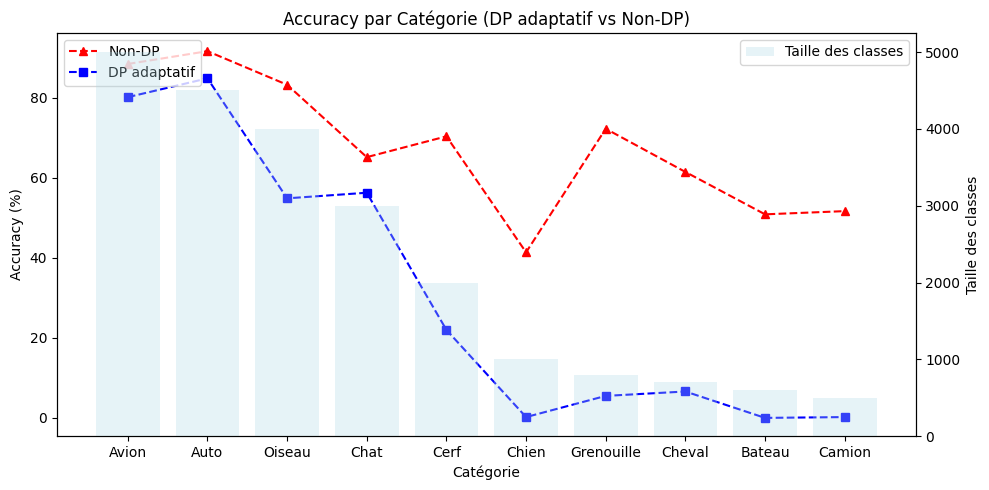

In [26]:
import matplotlib.pyplot as plt
# Affichage graphique optimisé
categories = ['Avion', 'Auto', 'Oiseau', 'Chat', 'Cerf', 'Chien', 'Grenouille', 'Cheval', 'Bateau', 'Camion']
class_sizes_list = [class_sizes[i] for i in range(10)]

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(categories, accuracy_nodp_per_class, 'r--^', label='Non-DP')
ax1.plot(categories, accuracy_dp_per_class, 'b--s', label='DP adaptatif')
ax2.bar(categories, class_sizes_list, alpha=0.3, color='lightblue', label='Taille des classes')
ax1.set_ylabel('Accuracy (%)')
ax2.set_ylabel('Taille des classes')
ax1.set_xlabel('Catégorie')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Accuracy par Catégorie (DP adaptatif vs Non-DP)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()